# Day2_work_通し課題：Kickstarter 

あるクラウドファンディングが成功するかを事前に予測するモデル作成する

## Day2を通して実装したこと

- ホールドアウト法
- 前処理：標準化
- 汎化誤差

## 結果

- 変数の分析はあまり進まなかった
- Day1と比較すると精度は上がった
- "iter"の数値を変えたが、変化がほとんどないため、変数が足りていない可能性があり、変数を増やす必要性がありそう

## 次回の目標

- 変数分析：一日の目標金額を出す…など
- モデル強化

#### 必要ライブラリのインポート

In [1]:
%matplotlib inline
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.linear_model import SGDClassifier
from sklearn.model_selection import train_test_split
import sklearn.svm

#### グラフの関数化

In [2]:
#散布図
def plot_scatter(df, col_nm_x, col_nm_y):
    plt.scatter(df[col_nm_x], df[col_nm_y])
    plt.xlabel(col_nm_x)
    plt.ylabel(col_nm_y)
    plt.show()
    return

#箱ひげ図
def plot_box(df, col_nm):
    df[col_nm].plot.box()
    plt.show()
    return

#ヒストグラム
def plot_hist(df, col_nm):
    plt.figure(figsize=(12,4))
    sns.distplot(df[col_nm]);
    return

#ヒートマップ
def plot_heatmap(df, var):
    plt.figure(figsize=(20, 20))
    sns.clustermap(df[var].corr(),annot=True,fmt='.2f')
    return

#ペアプロット
def plot_pairplot(df, var, hue):
    sns.pairplot(df, hue=hue, vars=var, size=5)
    return

#ストリッププロット
def plot_strip(df, col_x, col_y):
    sns.stripplot(data=df, x=col_x, y=col_y)
    return

#カテゴリプロット
def plot_cat_count(df, x, hue):
    sns.catplot(data=df, kind='count', x=x, hue=hue, height=7)
    return

#カウントプロット
def plot_count(df, col_nm):
    plt.figure(figsize=(20, 20))
    sns.countplot(x=col_nm, data=df)
    return

#### CSVファイル読み込み

In [3]:
#データフレームに復元
df_csv = pd.read_csv("./ks-projects-201801.csv")
df_csv.head()

,ID,name,category,main_category,currency,deadline,goal,launched,pledged,state,backers,country,usd pledged,usd_pledged_real,usd_goal_real
0,1000002330,The Songs of Adelaide & Abullah,Poetry,Publishing,GBP,2015-10-09,1000.0,2015-08-11 12:12:28,0.0,failed,0,GB,0.0,0.0,1533.95
1,1000003930,Greeting From Earth: ZGAC Arts Capsule For ET,Narrative Film,Film & Video,USD,2017-11-01,30000.0,2017-09-02 04:43:57,2421.0,failed,15,US,100.0,2421.0,30000.00
2,1000004038,Where is Hank?,Narrative Film,Film & Video,USD,2013-02-26,45000.0,2013-01-12 00:20:50,220.0,failed,3,US,220.0,220.0,45000.00
3,1000007540,ToshiCapital Rekordz Needs Help to Complete Album,Music,Music,USD,2012-04-16,5000.0,2012-03-17 03:24:11,1.0,failed,1,US,1.0,1.0,5000.00
4,1000011046,Community Film Project: The Art of Neighborhoo...,Film & Video,Film & Video,USD,2015-08-29,19500.0,2015-07-04 08:35:03,1283.0,canceled,14,US,1283.0,1283.0,19500.00


#### 訓練データとテストデータの分割（ホールドアウト法）

In [4]:
#訓練データ・テストデータ分割
test_size = 0.2
X = df_csv.values
X_train, X_test = train_test_split(X, test_size=test_size, random_state=1234) 

In [5]:
# 操作しづらいためデータフレーム化
df_train = pd.DataFrame(data=X_train, columns=df_csv.columns)
df_test = pd.DataFrame(data=X_test, columns=df_csv.columns)

#### 空白値確認

In [6]:
#空白値の確認
df_train.isnull().sum()

ID                     0
name                   2
category               0
main_category          0
currency               0
deadline               0
goal                   0
launched               0
pledged                0
state                  0
backers                0
country                0
usd pledged         3038
usd_pledged_real       0
usd_goal_real          0
dtype: int64

#### データ数の確認

In [7]:
df_train.count()

ID                  302928
name                302926
category            302928
main_category       302928
currency            302928
deadline            302928
goal                302928
launched            302928
pledged             302928
state               302928
backers             302928
country             302928
usd pledged         299890
usd_pledged_real    302928
usd_goal_real       302928
dtype: int64

#### 基本統計データの確認（最小値・最大値・平均値）

In [8]:
#describe：基本統計算出（数値のみ）min：最小,max；最大,mean：平均
df_train.describe()

,ID,name,category,main_category,currency,deadline,goal,launched,pledged,state,backers,country,usd pledged,usd_pledged_real,usd_goal_real
count,302928,302926,302928,302928,302928,302928,302928.0,302928,302928.0,302928,302928,302928,299890.0,302928.0,302928.0
unique,302928,300986,159,15,14,3155,7272.0,302575,52999.0,6,3590,23,80276.0,89131.0,43428.0
top,487063551,New EP/Music Development,Product Design,Film & Video,USD,2014-08-08,5000.0,1970-01-01 01:00:00,0.0,failed,0,US,0.0,0.0,5000.0
freq,1,28,17944,50999,236164,566,23817.0,6,41877.0,158010,44348,233977,54361.0,41877.0,19290.0


#### 目的変数の調査

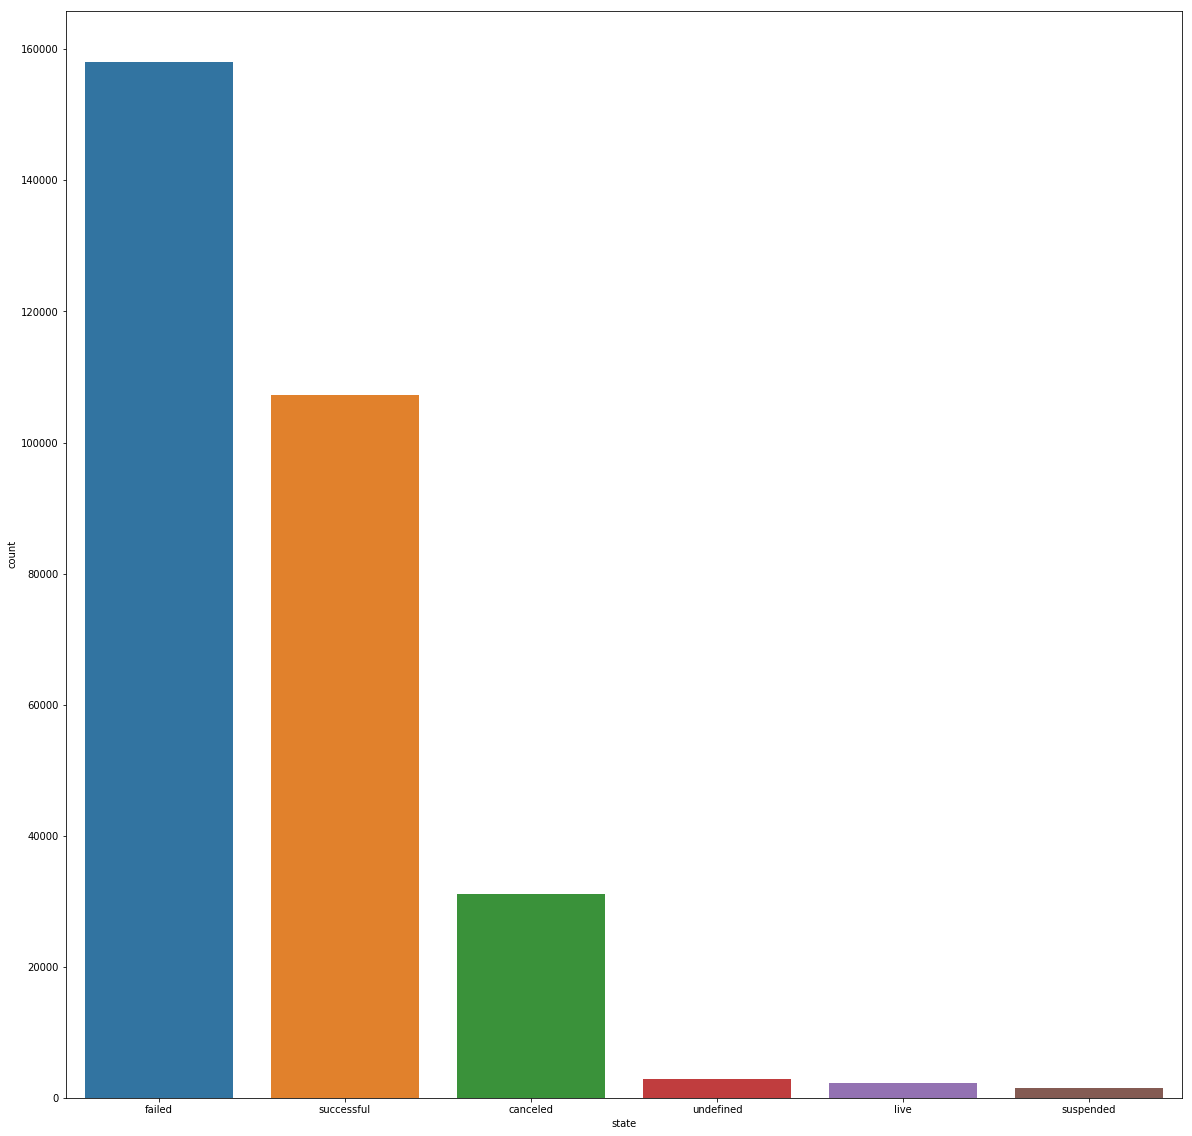

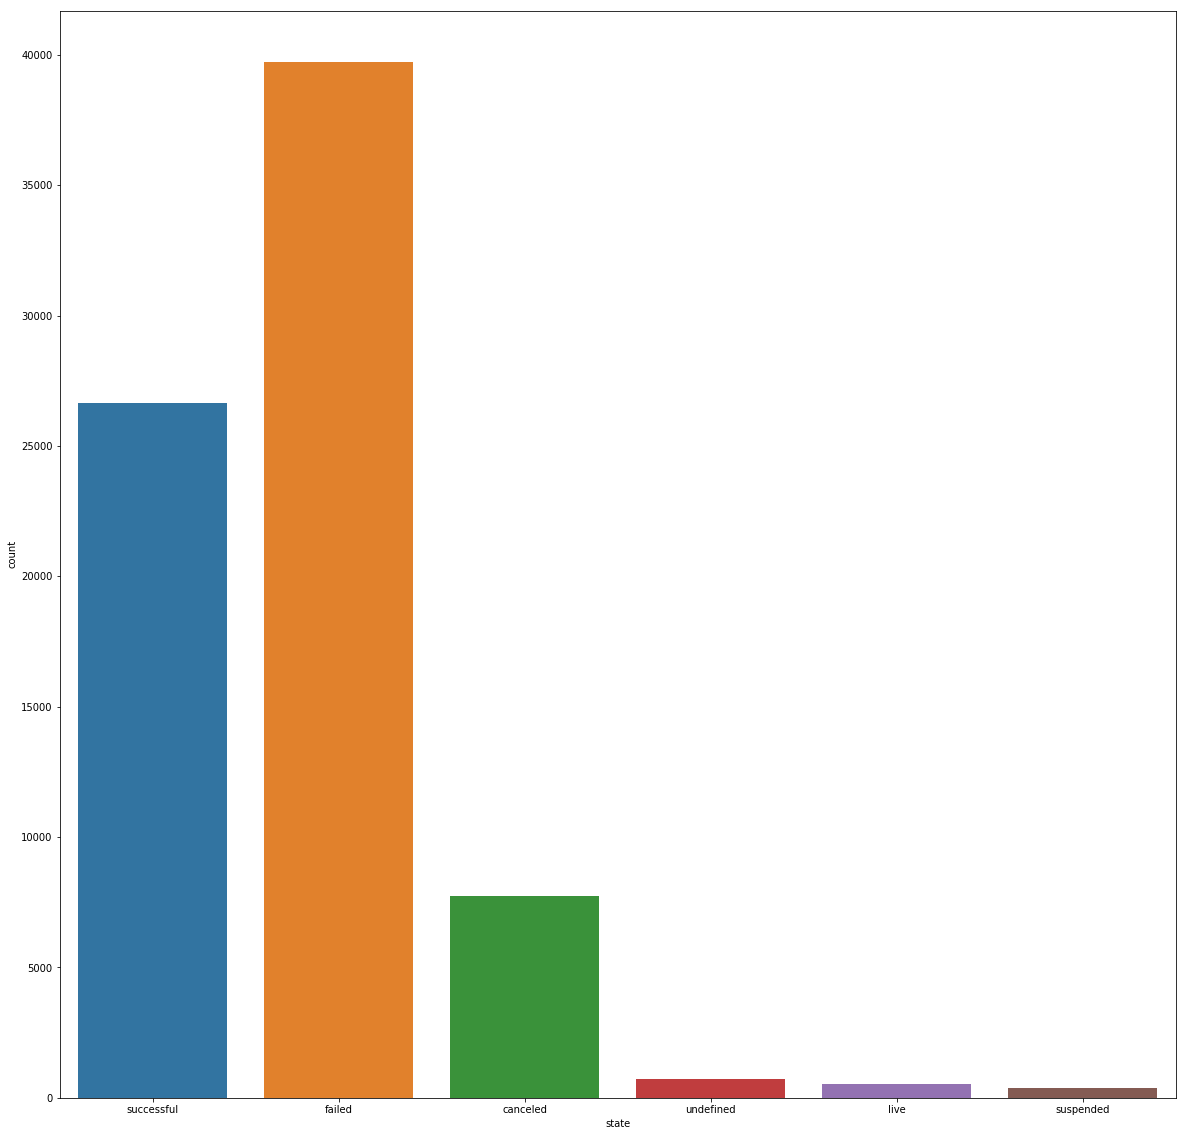

In [9]:
plot_count(df_train,'state')
plot_count(df_test,'state')

#### 外れ値が疑われるデータの確認

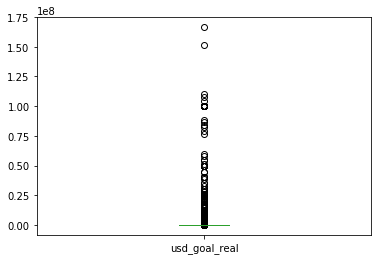

In [10]:
#対数化前:箱ひげ図
plot_box(df_train,'usd_goal_real')

#### カテゴリ数のばらつき確認

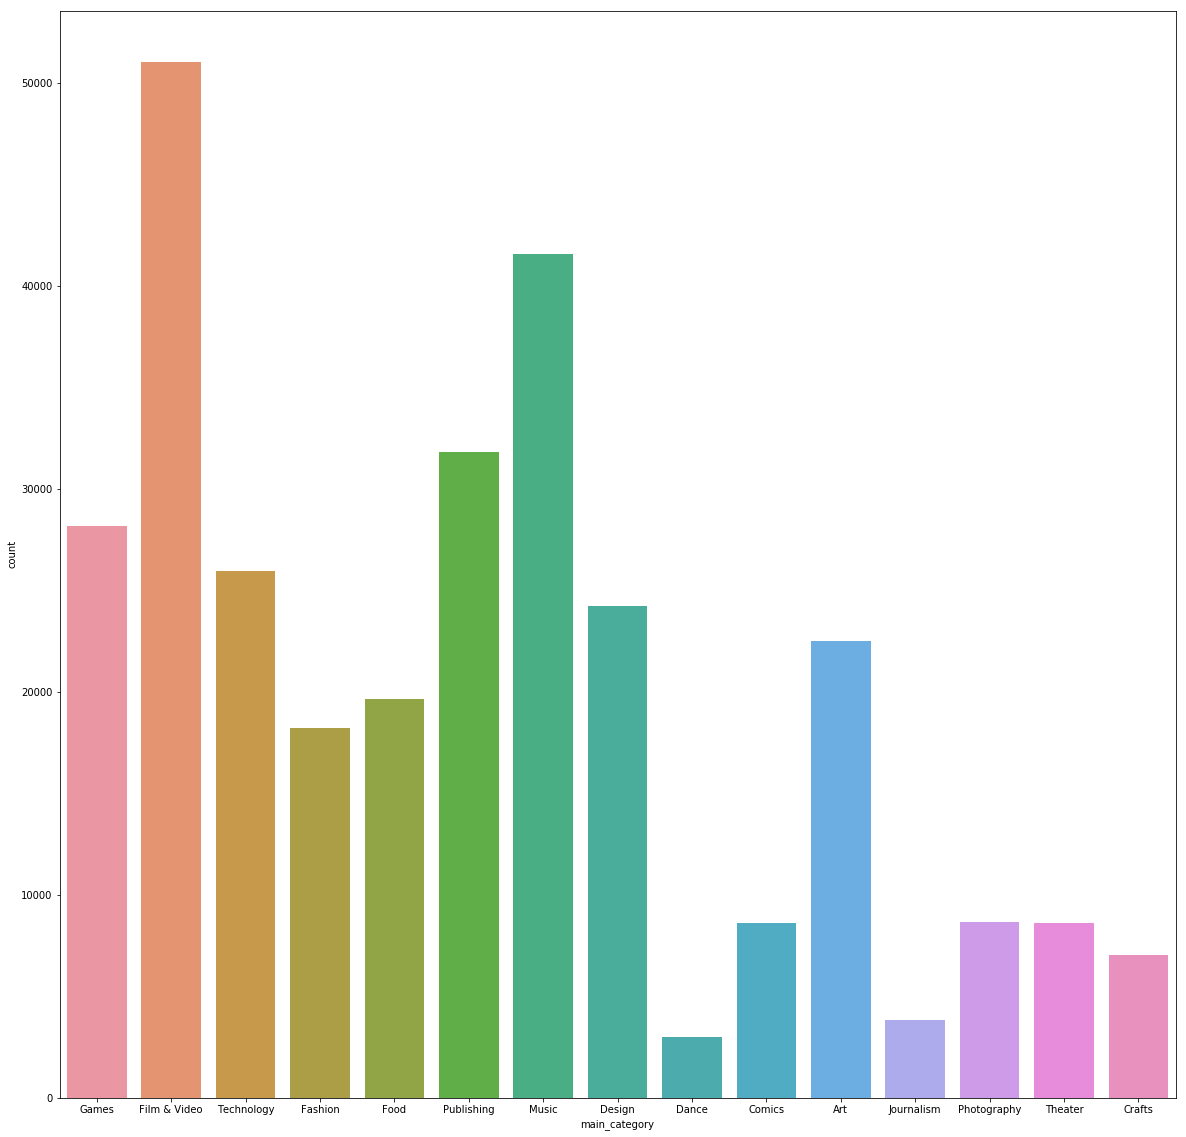

In [11]:
plot_count(df_train,'main_category')

#### 説明変数のラベル化　（ダミー変数の処理方法が分からなかった）

In [12]:
#質的変数を量的変数に変換:決定木モデルならone-hotよりlabelのほうがよい?
#そもそもダミー変数だらけになる
from sklearn.preprocessing import LabelEncoder

#ラベルを覚えさせる:訓練データのラベルだけを覚えさせる
le_main = LabelEncoder().fit(df_train['main_category'])
le_cat = LabelEncoder().fit(df_train['category'])
le_cur = LabelEncoder().fit(df_train['currency'])
le_cou = LabelEncoder().fit(df_train['country'])

#ラベルを整数に変換
def category_to_labels(df):
    df['main_category'] = le_main.transform(df['main_category'])
    df['category'] = le_cat.transform(df['category'])
    df['currency'] = le_cur.transform(df['currency'])
    df['country'] = le_cou.transform(df['country'])
    return df

In [13]:
#ダミー変数処理:処理方法がわからなかったため、ラベルを使用した。
#def convert_variables(df_csv):
    #df_csv=pd.get_dummies(df_csv, columns=["category", "main_category", "currency","country"], sparse=True)

#ダミー変数化したため、元の列が不必要となり、削除する
#df_csv.drop('category', axis=1, inplace=True)
#df_csv.drop('main_category', axis=1, inplace=True)
#df_csv.drop('currency', axis=1, inplace=True)
#df_csv.drop('country', axis=1, inplace=True)
#df_csv.head()


#### 目的変数の真理値に変換と必要のない説明変数削除

In [14]:
#成功か不成功かを判断したいのでsuccessful,failed以外は除外、下2行で#目的変数を真理値に変換
def convert_state(df):
    df = df[df['state'] != 'undefined']
    df = df[df['state'] != 'live']
    df = df[df['state'] != 'suspended']
    df = df[df['state'] != 'canceled']
    df.loc[df['state'] == 'failed', 'state'] = 0
    df.loc[df['state'] == 'successful', 'state'] = 1
    return df

In [15]:
#必要でなさそうな変数削除
def drop_colomn(df):
    df.drop('ID', axis=1, inplace=True)
    df.drop('name', axis=1, inplace=True)
    df.drop('pledged', axis=1, inplace=True)
    df.drop('backers', axis=1, inplace=True)
    df.drop('usd pledged', axis=1, inplace=True)
    df.drop('usd_pledged_real', axis=1, inplace=True)
    return df

#### 対数化

In [16]:
#前処理：対数化
def convert_log(df):   
    log_cols = ['usd_goal_real','goal']
    for l in log_cols:
        df[l] = np.log(df[l].astype(np.float64))
        df[l]= df[l].replace([np.inf, -np.inf], np.nan)
        df[l] = df[l].fillna(0)
    return df

In [17]:
#対数化後：箱ひげ図
#plot_box(df_csv,'usd_goal_real')
#対数化後：ヒストグラム
#plot_hist(df_csv,'usd_goal_real')

#### 日付差分の説明変数作成（span）

In [18]:
#日付データをfloatに変換
#df_csv['deadline'] = pd.to_datetime(df_csv['deadline'], format='%Y-%m-%d %H:%M:%S')
#df_csv['launched'] = pd.to_datetime(df_csv['launched'], format='%Y-%m-%d %H:%M:%S')
#df_csv['deadline'] = df_csv['deadline'].map(pd.Timestamp.timestamp)
#df_csv['launched'] = df_csv['launched'].map(pd.Timestamp.timestamp)
#df_csv.head()

In [19]:
#日付差分
def create_span_column(df):
    df['deadline'] = pd.to_datetime(df['deadline'], format='%Y-%m-%d %H:%M:%S')
    df['launched'] = pd.to_datetime(df['launched'], format='%Y-%m-%d %H:%M:%S')
    df['span'] = df['deadline'] - df['launched']
    df['span'] = df['span'].dt.days
    return df

In [20]:
#数値じゃないため、launched,deadlineを削除
def drop_date_column(df):
    df.drop('launched', axis=1, inplace=True)
    df.drop('deadline', axis=1, inplace=True)
    return df

#### 前処理実行

In [21]:
def preprocess(df):
    df = category_to_labels(df)
    df = convert_state(df)
    df = drop_colomn(df)
    df = convert_log(df)
    df = create_span_column(df)
    df = drop_date_column(df)
    return df

In [22]:
df_train = preprocess(df_train)
df_test = preprocess(df_test)

#### 標準化

In [23]:
#標準化処理
from sklearn.preprocessing import StandardScaler
stdsc = StandardScaler()
df_rows = ['goal','usd_goal_real','span']
#訓練データ用
for row in df_rows:
    df_train[row] = stdsc.fit_transform(df_train[[row]].values)
#テストデータ用
for row in df_rows:
    df_test[row] = stdsc.transform(df_test[[row]].values)

#df_train.head()

C:\Users\a-miyamoto\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\utils\validation.py:595: DataConversionWarning: Data with input dtype int64 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)
C:\Users\a-miyamoto\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\utils\validation.py:595: DataConversionWarning: Data with input dtype int64 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)
C:\Users\a-miyamoto\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\utils\validation.py:595: DataConversionWarning: Data with input dtype int64 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)


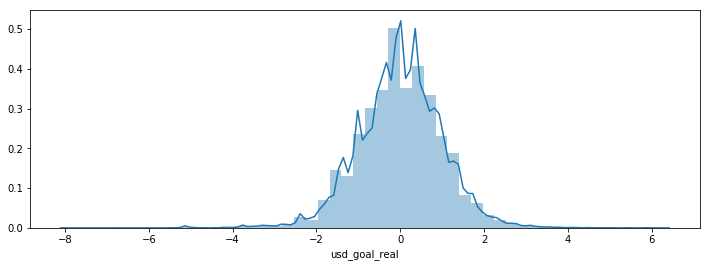

In [24]:
#標準化後のグラフ
plot_hist(df_train,'usd_goal_real')

#### 相関関係確認

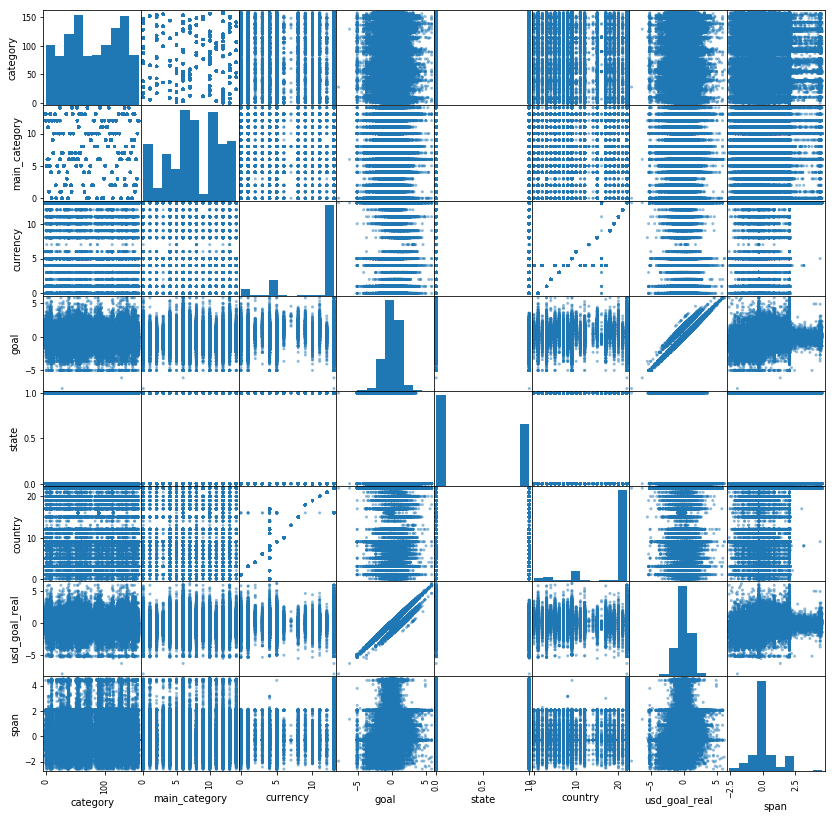

In [25]:
#相関係数（散布図）
df_csv.corr()
pd.plotting.scatter_matrix(df_train, figsize=(14,14))
plt.show()

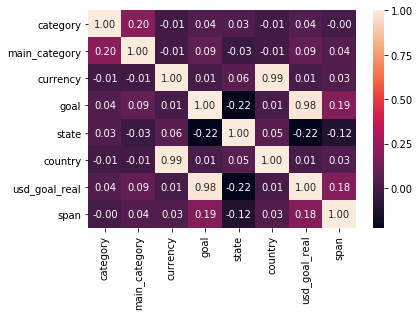

In [26]:
#相関係数（ヒートマップ）
sns.heatmap(df_train.corr(),annot=True,fmt='.2f')

#### 相関が高い変数の削除

In [27]:
#countryとcurrency：currencyは、USDドルに変換済みのため不要
#usd_goal_realとgoal:goalは、別の通貨が混じっているため必要ない
def drop_same_column(df):
    df.drop('currency', axis=1, inplace=True)
    df.drop('goal', axis=1, inplace=True)
    return df

In [28]:
df_train = drop_same_column(df_train)
df_test = drop_same_column(df_test)

#### 目的変数と説明変数の切り離し

In [29]:
#訓練データ・テストデータ分割
X_train = df_train.drop('state', axis=1).values
y_train = df_train["state"].values
X_test = df_test.drop('state', axis=1).values
y_test = df_test["state"].values

## モデル作成

#### ロジスティクス回帰（正則化なし）


In [30]:
def predict(X, y, clf):
    # ラベルを予測
    y_pred = clf.predict(X)

    # 正答率を計算:訓練誤差
    accuracy =  accuracy_score(y, y_pred)
    print('正答率（Train_Accuracy） = {:.3f}%'.format(100 * accuracy))
    
    # Precision, Recall, F1-scoreを計算
    precision, recall, f1_score, _ = precision_recall_fscore_support(y, y_pred)

    # Precision, Recall, F1-scoreを表示
    print('適合率（Train_Precision） = {:.3f}%'.format(100 * precision[1]))
    print('再現率（Train_Recall） = {:.3f}%'.format(100 * recall[1]))
    
    # クロス集計
    print()
    print(pd.DataFrame(confusion_matrix(y, y_pred), 
                        index=['正解 : 失敗', '正解 : 成功'], 
                        columns=['予測 : 失敗', '予測 : 成功']))

In [31]:
# ロジスティック回帰
from  sklearn.metrics import accuracy_score, precision_recall_fscore_support, confusion_matrix 
clf = SGDClassifier(loss='log', max_iter=10000, fit_intercept=True, random_state=1234, tol=1e-3)
clf.fit(X_train, y_train)

SGDClassifier(alpha=0.0001, average=False, class_weight=None,
       early_stopping=False, epsilon=0.1, eta0=0.0, fit_intercept=True,
       l1_ratio=0.15, learning_rate='optimal', loss='log', max_iter=10000,
       n_iter=None, n_iter_no_change=5, n_jobs=None, penalty='l2',
       power_t=0.5, random_state=1234, shuffle=True, tol=0.001,
       validation_fraction=0.1, verbose=0, warm_start=False)

#### 訓練誤差

In [32]:
predict(X_train,y_train, clf)

正答率（Train_Accuracy） = 60.010%
適合率（Train_Precision） = 57.368%
再現率（Train_Recall） = 4.372%

         予測 : 失敗  予測 : 成功
正解 : 失敗   154524     3486
正解 : 成功   102615     4691


#### 汎化誤差

In [33]:
predict(X_test,y_test, clf)

正答率（Train_Accuracy） = 56.728%
適合率（Train_Precision） = 43.957%
再現率（Train_Recall） = 28.184%

         予測 : 失敗  予測 : 成功
正解 : 失敗    30133     9576
正解 : 成功    19139     7511


#### ロジスティクス回帰（正則化）

In [34]:
# ロジスティック回帰
from  sklearn.metrics import accuracy_score, precision_recall_fscore_support, confusion_matrix 
clf_1 = SGDClassifier(loss='log', max_iter=10000, fit_intercept=True, random_state=1234, tol=1e-3, penalty='l1')
clf_1.fit(X_train, y_train)

SGDClassifier(alpha=0.0001, average=False, class_weight=None,
       early_stopping=False, epsilon=0.1, eta0=0.0, fit_intercept=True,
       l1_ratio=0.15, learning_rate='optimal', loss='log', max_iter=10000,
       n_iter=None, n_iter_no_change=5, n_jobs=None, penalty='l1',
       power_t=0.5, random_state=1234, shuffle=True, tol=0.001,
       validation_fraction=0.1, verbose=0, warm_start=False)

In [35]:
predict(X_train,y_train, clf_1)

正答率（Train_Accuracy） = 61.338%
適合率（Train_Precision） = 55.745%
再現率（Train_Recall） = 21.387%

         予測 : 失敗  予測 : 成功
正解 : 失敗   139791    18219
正解 : 成功    84357    22949


In [36]:
predict(X_test,y_test, clf_1)

正答率（Train_Accuracy） = 44.698%
適合率（Train_Precision） = 41.781%
再現率（Train_Recall） = 95.835%

         予測 : 失敗  予測 : 成功
正解 : 失敗     4121    35588
正解 : 成功     1110    25540


#### "max_iter" = 50000"に調整（正則化なし）

In [37]:
# ロジスティック回帰
from  sklearn.metrics import accuracy_score, precision_recall_fscore_support, confusion_matrix 
clf_2 = SGDClassifier(loss='log', max_iter=50000, fit_intercept=True, random_state=1234, tol=1e-3)
clf_2.fit(X_train, y_train)

SGDClassifier(alpha=0.0001, average=False, class_weight=None,
       early_stopping=False, epsilon=0.1, eta0=0.0, fit_intercept=True,
       l1_ratio=0.15, learning_rate='optimal', loss='log', max_iter=50000,
       n_iter=None, n_iter_no_change=5, n_jobs=None, penalty='l2',
       power_t=0.5, random_state=1234, shuffle=True, tol=0.001,
       validation_fraction=0.1, verbose=0, warm_start=False)

In [38]:
predict(X_train,y_train, clf_2)

正答率（Train_Accuracy） = 60.010%
適合率（Train_Precision） = 57.368%
再現率（Train_Recall） = 4.372%

         予測 : 失敗  予測 : 成功
正解 : 失敗   154524     3486
正解 : 成功   102615     4691


In [39]:
predict(X_test,y_test, clf_2)

正答率（Train_Accuracy） = 56.728%
適合率（Train_Precision） = 43.957%
再現率（Train_Recall） = 28.184%

         予測 : 失敗  予測 : 成功
正解 : 失敗    30133     9576
正解 : 成功    19139     7511


#### "max_iter" = 1000"に調整（正則化なし）

In [40]:
# ロジスティック回帰
from  sklearn.metrics import accuracy_score, precision_recall_fscore_support, confusion_matrix 
clf_3 = SGDClassifier(loss='log', max_iter=1000, fit_intercept=True, random_state=1234, tol=1e-3)
clf_3.fit(X_train, y_train)

SGDClassifier(alpha=0.0001, average=False, class_weight=None,
       early_stopping=False, epsilon=0.1, eta0=0.0, fit_intercept=True,
       l1_ratio=0.15, learning_rate='optimal', loss='log', max_iter=1000,
       n_iter=None, n_iter_no_change=5, n_jobs=None, penalty='l2',
       power_t=0.5, random_state=1234, shuffle=True, tol=0.001,
       validation_fraction=0.1, verbose=0, warm_start=False)

In [41]:
predict(X_train,y_train, clf_3)

正答率（Train_Accuracy） = 60.010%
適合率（Train_Precision） = 57.368%
再現率（Train_Recall） = 4.372%

         予測 : 失敗  予測 : 成功
正解 : 失敗   154524     3486
正解 : 成功   102615     4691


In [42]:
predict(X_test,y_test, clf_3)

正答率（Train_Accuracy） = 56.728%
適合率（Train_Precision） = 43.957%
再現率（Train_Recall） = 28.184%

         予測 : 失敗  予測 : 成功
正解 : 失敗    30133     9576
正解 : 成功    19139     7511


#### "max_iter" = 100"に調整（正則化なし）

In [43]:
# ロジスティック回帰
from  sklearn.metrics import accuracy_score, precision_recall_fscore_support, confusion_matrix 
clf_4 = SGDClassifier(loss='log', max_iter=100, fit_intercept=True, random_state=1234, tol=1e-3)
clf_4.fit(X_train, y_train)

C:\Users\a-miyamoto\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:603: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  ConvergenceWarning)


SGDClassifier(alpha=0.0001, average=False, class_weight=None,
       early_stopping=False, epsilon=0.1, eta0=0.0, fit_intercept=True,
       l1_ratio=0.15, learning_rate='optimal', loss='log', max_iter=100,
       n_iter=None, n_iter_no_change=5, n_jobs=None, penalty='l2',
       power_t=0.5, random_state=1234, shuffle=True, tol=0.001,
       validation_fraction=0.1, verbose=0, warm_start=False)

In [44]:
predict(X_train,y_train, clf_4)

正答率（Train_Accuracy） = 59.917%
適合率（Train_Precision） = 55.495%
再現率（Train_Recall） = 4.518%

         予測 : 失敗  予測 : 成功
正解 : 失敗   154122     3888
正解 : 成功   102458     4848


In [45]:
predict(X_test,y_test, clf_4)

正答率（Train_Accuracy） = 56.758%
適合率（Train_Precision） = 43.160%
再現率（Train_Recall） = 24.210%

         予測 : 失敗  予測 : 成功
正解 : 失敗    31212     8497
正解 : 成功    20198     6452
